In [21]:
import IPython
from td_utils import *
import numpy as np
from pydub import AudioSegment
%matplotlib inline

In [22]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

In [35]:
def load_raw_audio(path):
    positives = []
    backgrounds = []
    negatives = []
    for filename in os.listdir(path + "positives"):
        if filename.endswith("wav"):
            positive = AudioSegment.from_wav(path + "positives/" + filename)
            positives.append(positive)
    for filename in os.listdir(path + "backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav(
                path + "backgrounds/" + filename)
            backgrounds.append(background)
    for filename in os.listdir(path + "negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav(path + "negatives/" + filename)
            negatives.append(negative)
    return positives, negatives, backgrounds

In [36]:
# Load audio segments using pydub 
positives, negatives, backgrounds = load_raw_audio('./raw_data/')

print("background len should be 10,000, since it is a 10 sec clip\n" + str(len(backgrounds[0])),"\n")
print("activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) \n" + str(len(positives[0])),"\n")
print("activate[1] len: different `activate` clips can have different lengths\n" + str(len(positives[1])),"\n")

background len should be 10,000, since it is a 10 sec clip
10000 

activate[0] len may be around 1000, since an `activate` audio clip is usually around 1 second (but varies a lot) 
656 

activate[1] len: different `activate` clips can have different lengths
774 



In [38]:
def get_random_time_segment(segment_ms):
    """
    Gets a random time segment of duration segment_ms in a 10,000 ms audio clip.
    
    Arguments:
    segment_ms -- the duration of the audio clip in ms ("ms" stands for "milliseconds")
    
    Returns:
    segment_time -- a tuple of (segment_start, segment_end) in ms
    """
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms)   # Make sure segment doesn't run past the 10sec background 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

def is_overlapping(segment_time, previous_segments):
    """
    Checks if the time of a segment overlaps with the times of existing segments.
    
    Arguments:
    segment_time -- a tuple of (segment_start, segment_end) for the new segment
    previous_segments -- a list of tuples of (segment_start, segment_end) for the existing segments
    
    Returns:
    True if the time segment overlaps with any of the existing segments, False otherwise
    """
    
    segment_start, segment_end = segment_time
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Initialize overlap as a "False" flag. (≈ 1 line)
    overlap = False
    
    # Step 2: loop over the previous_segments start and end times.
    # Compare start/end times and set the flag to True if there is an overlap (≈ 3 lines)
    for previous_start, previous_end in previous_segments: # @KEEP
        if segment_start <= previous_end and segment_end >= previous_start:
            overlap = True
            break
    ### END CODE HERE ###

    return overlap

def insert_audio_clip(background, audio_clip, previous_segments):
    """
    Insert a new audio segment over the background noise at a random time step, ensuring that the 
    audio segment does not overlap with existing segments.
    
    Arguments:
    background -- a 10 second background audio recording.  
    audio_clip -- the audio clip to be inserted/overlaid. 
    previous_segments -- times where audio segments have already been placed
    
    Returns:
    new_background -- the updated background audio
    """
    
    # Get the duration of the audio clip in ms
    segment_ms = len(audio_clip)
    
    ### START CODE HERE ### 
    # Step 1: Use one of the helper functions to pick a random time segment onto which to insert 
    # the new audio clip. (≈ 1 line)
    segment_time = get_random_time_segment(segment_ms)
    
    # Step 2: Check if the new segment_time overlaps with one of the previous_segments. If so, keep 
    # picking new segment_time at random until it doesn't overlap. To avoid an endless loop
    # we retry 5 times(≈ 2 lines)
    retry = 5 # @KEEP 
    while is_overlapping(segment_time, previous_segments) and retry >= 0:
        segment_time = get_random_time_segment(segment_ms)
        retry = retry - 1
    ### END CODE HERE ###
        #print(segment_time)
    # if last try is not overlaping, insert it to the background
    if not is_overlapping(segment_time, previous_segments):
    ### START CODE HERE ### 
        # Step 3: Append the new segment_time to the list of previous_segments (≈ 1 line)
        previous_segments.append(segment_time)
    ### END CODE HERE ###
        # Step 4: Superpose audio segment and background
        new_background = background.overlay(audio_clip, position = segment_time[0])
    else:
        #print("Timeouted")
        new_background = background
        segment_time = (10000, 10000)
    
    return new_background, segment_time

def insert_ones(y, segment_end_ms):
    """
    Update the label vector y. The labels of the 50 output steps strictly after the end of the segment 
    should be set to 1. By strictly we mean that the label of segment_end_y should be 0 while, the
    50 following labels should be ones.
    
    
    Arguments:
    y -- numpy array of shape (1, Ty), the labels of the training example
    segment_end_ms -- the end time of the segment in ms
    
    Returns:
    y -- updated labels
    """
    _, Ty = y.shape
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    if segment_end_y < Ty:
        # Add 1 to the correct index in the background label (y)
        ### START CODE HERE ### (≈ 3 lines)
        for i in range(segment_end_y+1, segment_end_y+51):
            if i < Ty:
                y[0, i] = 1
        ### END CODE HERE ###
    
    return y

In [39]:
def create_training_example(background, activates, negatives, Ty, file_index):
    """
    Creates a training example with a given background, activates, and negatives.
    
    Arguments:
    background -- a 10 second background audio recording
    activates -- a list of audio segments of the word "activate"
    negatives -- a list of audio segments of random words that are not "activate"
    Ty -- The number of time steps in the output

    Returns:
    x -- the spectrogram of the training example
    y -- the label at each time step of the spectrogram
    """
    
    # Make background quieter
    background = background - 20

    ### START CODE HERE ###
    # Step 1: Initialize y (label vector) of zeros (≈ 1 line)
    y = np.zeros((1, Ty))

    # Step 2: Initialize segment times as empty list (≈ 1 line)
    previous_segments = []
    ### END CODE HERE ###
    
    # Select 0-4 random "activate" audio clips from the entire list of "activates" recordings
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]
    
    ### START CODE HERE ### (≈ 3 lines)
    # Step 3: Loop over randomly selected "activate" clips and insert in background
    for random_activate in random_activates: # @KEEP
        # Insert the audio clip on the background
        background, segment_time = insert_audio_clip(background, random_activate, previous_segments)
        # Retrieve segment_start and segment_end from segment_time
        segment_start, segment_end = segment_time
        # Insert labels in "y" at segment_end
        y = insert_ones(y, segment_end)
    ### END CODE HERE ###

    # Select 0-2 random negatives audio recordings from the entire list of "negatives" recordings
    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    ### START CODE HERE ### (≈ 2 lines)
    # Step 4: Loop over randomly selected negative clips and insert in background
    for random_negative in random_negatives: # @KEEP
        # Insert the audio clip on the background 
        background, _ = insert_audio_clip(background, random_negative, previous_segments)
    ### END CODE HERE ###
    
    # Standardize the volume of the audio clip 
    background = match_target_amplitude(background, -20.0)

    # Export new training example
    file_name = f"./raw_data/training/train_{file_index}.wav" 
    file_handle = background.export(file_name, format="wav")
    
    # Get and plot spectrogram of the new recording (background with superposition of positive and negatives)
    x = graph_spectrogram(file_name)
    
    return x, y

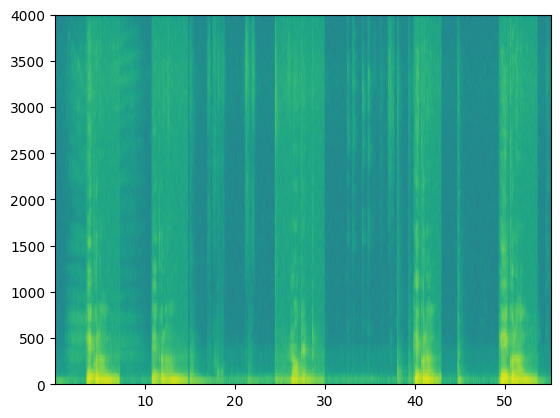

In [41]:
x,y = create_training_example(backgrounds[1],positives,negatives,1375,1)

In [45]:
print(y)

[[0. 0. 0. ... 1. 1. 1.]]


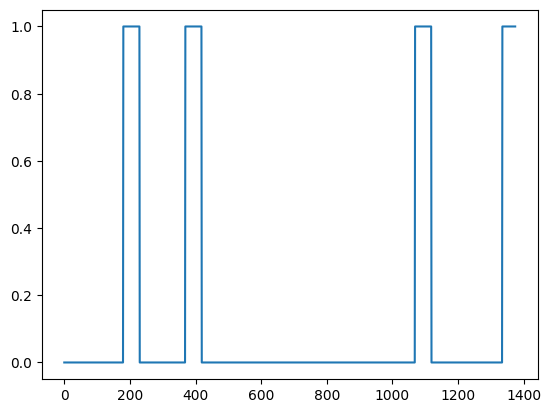

In [46]:
plt.plot(y[0])

In [47]:
IPython.display.Audio("train.wav")